In [11]:
import cobra
import pandas as pd
import re
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
import leakage

In [4]:
model = cobra.io.read_sbml_model('../../models/e_coli/momentiJO1366.xml')
model.reactions.DHAPT.knock_out()
model.reactions.THRA.knock_out()
model.reactions.THRA2.knock_out()
model.reactions.F6PA_TG_forward.knock_out()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-26


In [9]:
met_info_df = pd.read_csv("../../data/met_info_curated.csv", encoding = "ISO-8859-1", index_col = 0)

# Get leakage

In [12]:
time = 6
exometabolites_folder = Path("../../data/e_coli/")
leakage_df = leakage.get_leakage(exometabolites_folder, "ecoli", time = time, unit = '/gDW')
leakage_df.set_index("Metabolite", inplace=True)
leakage_df.drop_duplicates(inplace=True)
leakage_label = "Leakage (mM/gDW/h)"

In [14]:
# Read metabolite mapping
mapping_df = pd.read_csv('../../data/e_coli/abbrev_to_id.csv', index_col=0)
leakage_df = leakage_df.join(mapping_df)


In [35]:
leakage_df.head()

,Leakage (mM/gDW/h),met id
Metabolite,,
G6P,2.112709,g6p
F6P,2.310546,f6p
FBP,0.022204,fdp
DHAP,2.581162,dhap
GA3P,0.396769,g3p


In [78]:
df = pd.merge(met_info_df, leakage_df, left_on = 'Metabolite id', right_on = 'met id')

In [79]:
df.head()

,Metabolite name,Metabolite id,Value,Uncertainty,Mass,Charge,Phosphate,Topological Polar Surface Area [Å],Concentration,logP,Hydrophobicity index,Shadow price,Turnover,Leakage (mM/gDW/h),met id
0,Glucose-6-phosphate,g6p,17.65,0.53,258.119901,-2.0,1,165.0,0.003000,NaN,NaN,-0.017544,10.000000,2.112709,g6p
1,Fructose-6-phosphate,f6p,29.29,0.60,258.119901,-2.0,1,165.0,0.003000,NaN,NaN,-0.017632,2.460728,2.310546,f6p
2,"Fructose-1,6-bisphosphate",fdp,34.21,0.72,336.083922,-4.0,2,215.0,0.015200,NaN,NaN,-0.024706,2.277172,0.022204,fdp
3,Dihydroxyacetonephosphate,dhap,50.40,1.74,168.041961,-2.0,1,104.0,0.000374,NaN,NaN,-0.014695,2.277172,2.581162,dhap
4,Glyceraldehyde-3-phosphate,g3p,15.04,0.24,168.041961,-2.0,1,104.0,NaN,NaN,NaN,-0.014699,11.535426,0.396769,g3p


In [80]:
df.drop(columns=['logP', 'Hydrophobicity index', 'Value', 'Uncertainty', 'met id', 'Topological Polar Surface Area [Å]'], inplace = True)

# Get logP values

In [16]:
import pubchempy as pcp

In [81]:
xlogp_list = []
for i, row in df.iterrows():
    met_ids = row['Metabolite id'].split(', ')
    xlogp_temp_list = []
    for m_id in met_ids:
        m = model.metabolites.get_by_id('{0}_c'.format(m_id))
        result = pcp.get_compounds(m.name, 'name')
        for r in result:
            print(m.id, r.xlogp)
            xlogp_temp_list.append(r.xlogp)
    xlogp_list.append(np.mean(xlogp_temp_list))

g6p_c -4.5
g6p_c -4.5
f6p_c -4.3


/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ssulheim/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dhap_c -2.5
g3p_c -2.7
g3p_c -2.8
pep_c -1.1
pyr_c -0.6
r5p_c -3.6
ru5p__D_c -3.7
ru5p__L_c -3.7
xu5p__D_c -3.7
xu5p__L_c -3.7
e4p_c -3.3
cit_c 0.2
acon_C_c -1
icit_c -1.8
akg_c -0.9
fum_c 1
fum_c -0.3
ala__L_c -3
val__L_c -2.3
asp__L_c -2.8
hom__L_c -4.4
thr__L_c -2.9
met__L_c -1.9
trp__L_c -1.1
tyr__L_c -2.3
phe__L_c -1.5
glu__L_c -3.7
pro__L_c -2.5
ser__L_c -3.1
gly_c -3.2
arg__L_c -4.2
his__L_c -3.2
ac_c 0.4
ura_c -1.1


In [82]:
xlogp_list

[-4.5,
 -4.3,
 nan,
 -2.5,
 -2.75,
 -1.1,
 -0.6,
 -3.6,
 -3.7,
 -3.3,
 0.2,
 -1.0,
 -1.8,
 -0.9,
 0.35,
 -3.0,
 -2.3,
 -2.8,
 -4.4,
 -2.9,
 -1.9,
 -1.1,
 -2.3,
 -1.5,
 -3.7,
 -2.5,
 -3.1,
 -3.2,
 -4.2,
 -3.2,
 0.4,
 nan,
 -1.1]

In [83]:
df['log P'] = xlogp_list

In [85]:
df.loc[df['Metabolite id']=='fdp', 'log P'] = -5.9# https://pubchem.ncbi.nlm.nih.gov/compound/Fructose-1_6-bisphosphate#section=Computed-Properties
df.loc[df['Metabolite id']=='orot', 'log P'] = -0.8#https://pubchem.ncbi.nlm.nih.gov/compound/1492348#section=Chemical-and-Physical-Properties

# Get shadow prices and turnover flux

In [86]:
def get_turnover_flux(m, solution):
    total_flux = 0
    for r in m.reactions:
        flux_r = solution.fluxes[r.id]*r.get_coefficient(m_id)
        if flux_r > 0:
            total_flux += flux_r
    return total_flux


In [62]:
#sp = solution.shadow_prices
all_shadow_prices = leakage.estimate_shadow_prices(model, delta=0.01)

In [107]:
# FBA
# I choose glucose uptake so low that there is no overflow metabolism
glucose_uptake = 10
model.reactions.EX_glc__D_e.lower_bound = -glucose_uptake
solution = model.optimize()

turnover = {}
shadow_prices = {}
for i, row in df.iterrows():
    m_text = row["Metabolite id"]
    try:
        keys = m_text.split(",")
    except:
        print(m_text)
        continue
    sp_list = []
    turnover_list = []
    for key in keys:
        m_id = "{0}_c".format(key.strip())
        m = model.metabolites.get_by_id(m_id)
        sp_list.append(all_shadow_prices[m.id])
        turnover_list.append(get_turnover_flux(m, solution))
    shadow_prices[i] = np.nanmean(sp_list)
    turnover[i] = np.mean(turnover_list)

In [108]:
shadow_prices

{0: -0.017543793138197206,
 1: -0.017632289708258142,
 2: -0.024705658537049757,
 3: -0.014695471423087358,
 4: -0.014699159287157038,
 5: -0.010588820636914242,
 6: -0.004273048291925097,
 7: -0.017209209894908373,
 8: -0.01714945324993537,
 9: -0.016153374804617204,
 10: -0.016386147376246107,
 11: -0.0172673257966105,
 12: -0.018148504217152528,
 14: -0.012332913416523983,
 15: -0.008157997084567992,
 16: -0.08202055347327208,
 17: -0.013386557957095757,
 18: -0.028681518661288763,
 19: -0.037871551269075265,
 20: -0.27290646407210906,
 21: -0.20387805775012868,
 22: -0.0565279633625404,
 23: -0.056438291073956925,
 24: -0.01842738561101953,
 25: -0.028113133890128594,
 26: -0.07190642340525466,
 27: -0.10644863653568315,
 28: -0.10986854166281645,
 29: -0.15542805340692523,
 30: -0.0003658776720039114,
 31: -0.01995349824807091}

In [88]:
# # With glucose uptake = 3, there is a small flux "inconcistency" with accoa, gicing a positive shadow price
# with model:
#     model.add_boundary(model.metabolites.accoa_c, "demand")
#     model.optimize()
#     print(model.summary())

In [109]:
df["Shadow price"] = pd.Series(shadow_prices)
df["Turnover"] = pd.Series(turnover)

/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_13142/4098696825.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Shadow price"] = pd.Series(shadow_prices)
/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_13142/4098696825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Turnover"] = pd.Series(turnover)


In [110]:
df

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Concentration,Shadow price,Turnover,Leakage (mM/gDW/h),log P,log10_value,log10_sp,log10_conc
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,0.003000,-0.017544,10.000000,2.112709,-4.50,0.324840,-1.755877,2.522879
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,0.003000,-0.017632,2.460728,2.310546,-4.30,0.363715,-1.753691,2.522879
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,0.015200,-0.024706,2.277172,0.022204,-5.90,-1.653572,-1.607204,1.818156
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,0.000374,-0.014695,2.277172,2.581162,-2.50,0.411815,-1.832816,3.427128
4,Glyceraldehyde-3-phosphate,g3p,168.041961,-2.0,1,0.005803,-0.014699,11.535426,0.396769,-2.75,-0.401462,-1.832708,2.236338
5,Phosphoenolpyruvate,pep,165.018141,-3.0,1,0.000184,-0.010589,10.217296,0.311559,-1.10,-0.506460,-1.975152,3.735182
6,Pyruvate,pyr,87.054120,-1.0,0,0.005803,-0.004273,17.005051,571.725346,-0.60,2.757187,-2.369262,2.236338
7,Ribose-5-phosphate,r5p,228.093921,-2.0,1,0.000450,-0.017209,0.723669,0.450142,-3.60,-0.346650,-1.764239,3.346787
8,Ribu-/Xylulose-5-phosphate,"ru5p__D, ru5p__L, xu5p__D, xu5p__L",228.093921,-2.0,1,0.000900,-0.017149,0.218006,0.231484,-3.70,-0.635479,NaN,3.045757
9,Erythrose-4-phosphate,e4p,198.067941,-2.0,1,0.005803,-0.016153,0.245469,0.086179,-3.30,-1.064598,-1.791737,2.236338


# Make predictions

In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, ARDRegression, BayesianRidge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from scipy import stats



In [112]:
df = df.loc[df['Leakage (mM/gDW/h)'] > 0, :]
df.loc[df.Concentration.isna(), 'Concentration'] = np.mean(df.Concentration)
df["log10_value"] = np.log10(df['Leakage (mM/gDW/h)'])

In [113]:

df["log10_sp"] = np.log10(np.abs(df[["Shadow price"]]))
df["log10_conc"] = np.abs(np.log10(df.Concentration))

In [114]:
df.head()

,Metabolite name,Metabolite id,Mass,Charge,Phosphate,Concentration,Shadow price,Turnover,Leakage (mM/gDW/h),log P,log10_value,log10_sp,log10_conc
0,Glucose-6-phosphate,g6p,258.119901,-2.0,1,0.003000,-0.017544,10.000000,2.112709,-4.50,0.324840,-1.755877,2.522879
1,Fructose-6-phosphate,f6p,258.119901,-2.0,1,0.003000,-0.017632,2.460728,2.310546,-4.30,0.363715,-1.753691,2.522879
2,"Fructose-1,6-bisphosphate",fdp,336.083922,-4.0,2,0.015200,-0.024706,2.277172,0.022204,-5.90,-1.653572,-1.607204,1.818156
3,Dihydroxyacetonephosphate,dhap,168.041961,-2.0,1,0.000374,-0.014695,2.277172,2.581162,-2.50,0.411815,-1.832816,3.427128
4,Glyceraldehyde-3-phosphate,g3p,168.041961,-2.0,1,0.005803,-0.014699,11.535426,0.396769,-2.75,-0.401462,-1.832708,2.236338


In [353]:
columns = ["log10_sp", "Turnover", "Mass", "Charge", "Phosphate", 'log P']#"Concentration", "Shadow price", "log10_conc", 



## Make train and test set

In [354]:
data = StandardScaler().fit_transform(df[columns])
X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.1)#, random_state=40)


In [357]:
N = 100
coefficients = np.zeros((6,N))*np.nan

R2_arr = np.zeros(N)
R2_arr_test = np.zeros(N)
data = StandardScaler().fit_transform(df[columns])

for i in range(N):
    X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.05)
    linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)
    coefficients[:, i] = linear_reg.coef_
    R2_arr[i] = linear_reg.score(X_train, y_train)


In [358]:
len(coefficients.mean(axis = 1)), len(columns)

(6, 6)

<BarContainer object of 6 artists>

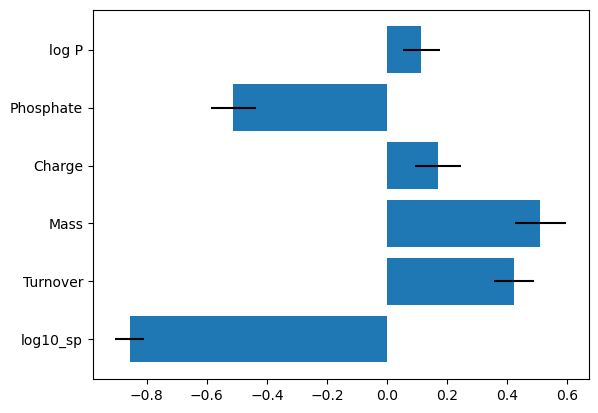

In [359]:
plt.barh(columns, coefficients.mean(axis=1), xerr = coefficients.std(axis=1))

<BarContainer object of 1 artists>

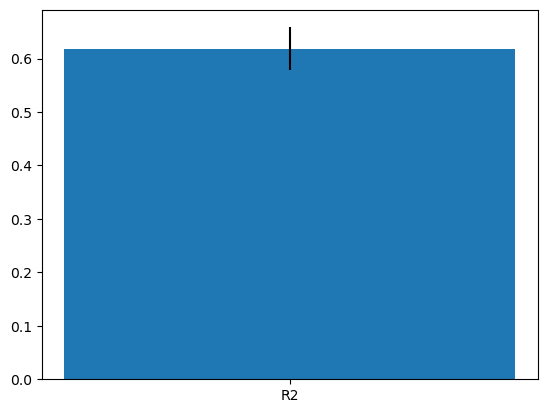

In [360]:
plt.bar(["R2"], [R2_arr.mean()], yerr = [R2_arr.std()])

# Test multiple different linear models

In [316]:
columns = ["log10_sp"]#, "log10_conc", "Turnover", "Mass", "Charge", "Phosphate", 'log P']#"Concentration", "Shadow price", 


In [317]:
from itertools import chain, combinations

def powerset(iterable):
    """
    powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return chain.from_iterable(combinations(xs,n) for n in range(len(xs)+1))



In [318]:
all_sets = [list(x) for x in powerset(columns) if len(x)]

In [319]:
all_sets[-10:]

[['log10_sp']]

In [320]:
def adj_r2(r2, n, p):
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

In [321]:
R2_mean = np.zeros(len(all_sets))
R2_adj = np.zeros(len(all_sets))
R2_std = np.zeros(len(all_sets))
loo = LeaveOneOut()

for i, model in enumerate(all_sets):
    temp_arr = np.zeros(data.shape[0])
    data = StandardScaler().fit_transform(df[model])
    for j, (train_index, test_index) in enumerate(loo.split(data)):
        X = data[train_index, :]
        y =  df.log10_value.values[train_index]
        linear_reg = LinearRegression(fit_intercept = True).fit(X, y)
        #coefficients[:, i] = linear_reg.coef_
        temp_arr[j] = linear_reg.score(X, y)
    R2_mean[i] = temp_arr.mean()
    R2_adj[i] = adj_r2(temp_arr.mean(), len(temp_arr), len(model))
    R2_std[i] = temp_arr.std()

In [322]:
idx = R2_mean.argsort()

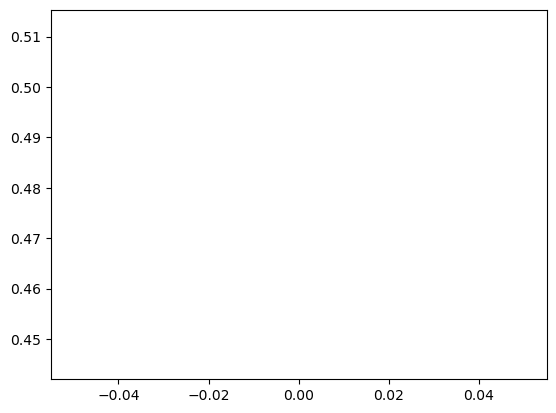

In [324]:
plt.plot(np.arange(len(idx)), R2_mean[idx])
plt.fill_between(np.arange(len(idx)), R2_mean[idx]-R2_std[idx], R2_mean[idx]+R2_std[idx], alpha = 0.5)

# Statsmodels

In [150]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Look at correlation between variables

In [346]:
# columns =  ["Turnover", "Mass", "Charge", "Phosphate", "Topological Polar Surface Area [Å]","log10_sp", "log10_conc", "Shadow price", "Concentration"]
# columns =  ["log10_sp", "Charge"] #"log10_value" "Topological Polar Surface Area [Å]", 
data = StandardScaler().fit_transform(df[columns])

In [326]:
df_i = df[columns]
rho = df_i.corr()
pval = df_i.corr(method=lambda x, y: st.pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

,log10_sp
log10_sp,1.0***


In [327]:
pval

,log10_sp
log10_sp,0.0


In [337]:
data = sm.add_constant(data)

In [347]:
data.shape, y.size

((31, 1), 31)

In [348]:
y = StandardScaler().fit_transform(df.log10_value.values[:, np.newaxis])

In [340]:
y.std()

1.0000000000000002

In [349]:
ols_model = sm.OLS(y, data)

In [350]:
results = ols_model.fit()

In [351]:
df[columns].columns

Index(['log10_sp'], dtype='object')

In [352]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.479
Model:                            OLS   Adj. R-squared (uncentered):              0.462
Method:                 Least Squares   F-statistic:                              27.63
Date:                Mon, 03 Apr 2023   Prob (F-statistic):                    1.13e-05
Time:                        23:12:49   Log-Likelihood:                         -33.869
No. Observations:                  31   AIC:                                      69.74
Df Residuals:                      30   BIC:                                      71.17
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Define function to estimate confidence intervals

## Linear model

In [395]:
data = StandardScaler().fit_transform(df[columns])
X_train, X_test, y_train, y_test = train_test_split(data, df.log10_value, test_size=0.2)#, random_state=40)

linear_reg = LinearRegression(fit_intercept = True).fit(X_train, y_train)

In [396]:
lin_pred = linear_reg.predict(X_test)

In [397]:
print(linear_reg.score(X_train, y_train))
print(linear_reg.score(X_test, y_test))

0.607237810400629
0.29233524187338844


<BarContainer object of 6 artists>

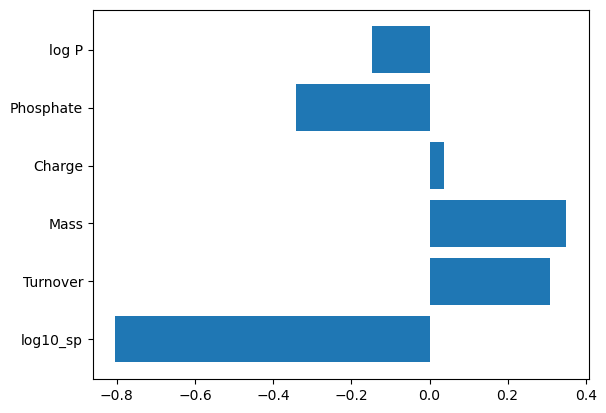

In [398]:
plt.barh(columns , linear_reg.coef_)

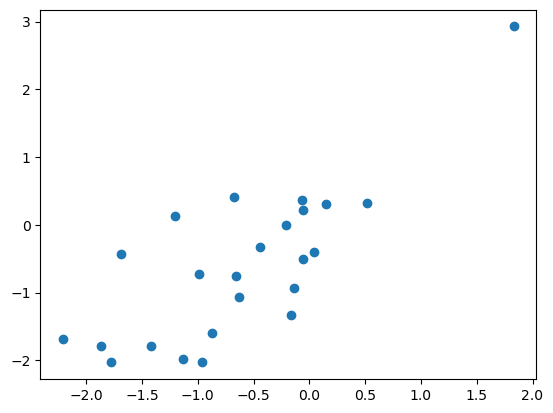

In [399]:
plt.scatter(linear_reg.predict(X_train), y_train)

## Lasso

In [400]:
lasso_reg = Lasso(fit_intercept = True, alpha = 0.01).fit(X_train, y_train)

In [401]:
print(lasso_reg.score(X_train, y_train))
print(lasso_reg.score(X_test, y_test))

0.6050865316327687
0.25714633345381777


<BarContainer object of 6 artists>

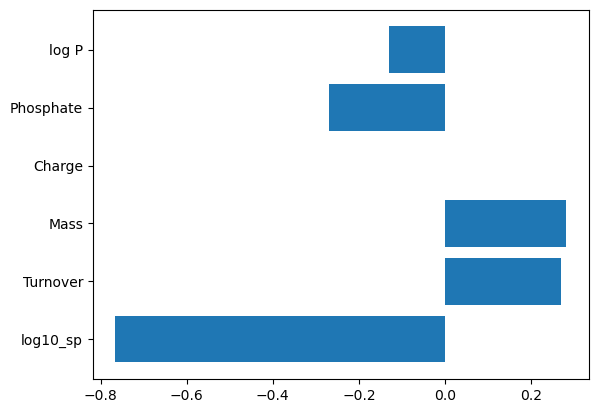

In [402]:
plt.barh(columns , lasso_reg.coef_)

# Elastic net

In [403]:
EN_reg = ElasticNet(alpha = 0.001).fit(X_train, y_train)

In [404]:
EN_pred = EN_reg.predict(X_test)
print(EN_reg.score(X_train, y_train))
print(EN_reg.score(X_test, y_test))

0.6072274331911987
0.29000674688294037


<BarContainer object of 6 artists>

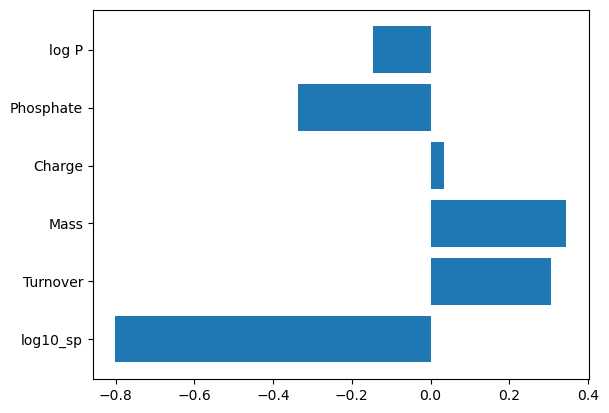

In [405]:
plt.barh(columns , EN_reg.coef_)

## Random forest

In [406]:
rf_reg = RandomForestRegressor().fit(X_train, y_train)

In [407]:
rf_pred = rf_reg.predict(X_test)

In [408]:
print(rf_reg.score(X_train, y_train))
print(rf_reg.score(X_test, y_test))

0.9197807221166385
-0.451585196644662


RandomForestRegressor()

## Decision tree

In [378]:
tree_reg = tree.DecisionTreeRegressor().fit(X_train, y_train)

In [379]:
tree_pred = tree_reg.predict(X_test)

In [380]:
print(tree_reg.score(X_train, y_train))
print(tree_reg.score(X_test, y_test))

1.0
-0.40784768564515095


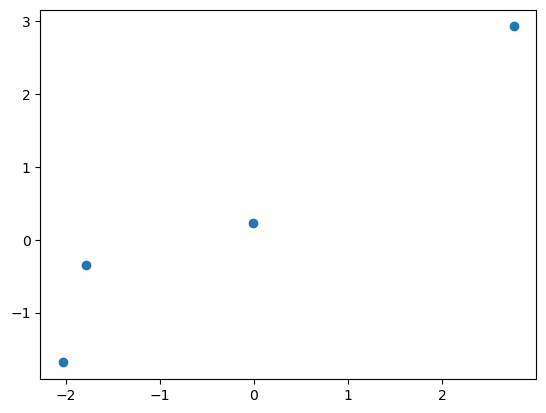

In [310]:
plt.scatter(tree_pred, y_test)

In [311]:
ard_reg = BayesianRidge(alpha_init=0.1, lambda_init=0.01).fit(X_train, y_train)

In [312]:
print(ard_reg.score(X_train, y_train))
print(ard_reg.score(X_test, y_test))

0.49019175016526784
0.7275372934361742


In [313]:
from sklearn.neural_network import MLPRegressor

In [314]:
MLP_reg = MLPRegressor(max_iter = 1000).fit(X_train, y_train)

In [315]:
print(MLP_reg.score(X_train, y_train))
print(MLP_reg.score(X_test, y_test))

0.9760784223482319
0.9109427355453426


[array([[ 0.18013351, -0.18151567,  0.12642034, -0.05617019,  0.00987986,
          0.00731731,  0.15084528,  0.09732818,  0.09153956, -0.07128596,
          0.25849024, -0.23289872, -0.04644276, -0.01279582,  0.15689094,
          0.31508104, -0.01638097,  0.30301362, -0.01731219, -0.18855022,
          0.17952468, -0.09144234, -0.19555564, -0.12586062,  0.15982066,
          0.1345942 ,  0.18493138,  0.23957611,  0.00478899, -0.03106493,
          0.17839147, -0.02238844,  0.31277231, -0.14683018,  0.09904009,
         -0.00179072, -0.17942071, -0.05809929,  0.12016301, -0.12260145,
          0.07941516,  0.04842748, -0.1038866 ,  0.09002151,  0.26457866,
         -0.1043415 , -0.06652327, -0.11799308, -0.30485799, -0.04079448,
          0.09851252, -0.1716397 , -0.00731401, -0.23605771, -0.06021398,
         -0.01207341, -0.11827515, -0.15948293, -0.09148907, -0.07882032,
         -0.046759  , -0.23048956,  0.11800451, -0.18926228,  0.10650232,
         -0.17340069,  0.00392482, -0.